In [1]:
import pandas as pd

# Read the CSV file into a pandas DataFrame
df = pd.read_csv('../01_preprocess/preprocessed.csv')
# Calculate the percentile brackets
df['percentile bracket'] = pd.qcut(df['time'], q=10, labels=False, duplicates='drop') + 1

df.drop(['cycle', 'instr', 'LLC_miss','CPU','L1_miss', 'br_miss', 'scale', 'counted_final_key_count', 'GHz', 'time', 'task', 'IPC'], axis=1, inplace=True)
df.drop(['nodeCount_Leaf', 'nodeCount_Inner', 'nodeCount_Dense', 'nodeCount_Hash', 'nodeCount_Head4', 'nodeCount_Head8', 'nodeCount_Dense2'], axis=1, inplace=True)

df.head()

,config_name,const_basicHintCount,const_enableBasicHead,const_enableDense,const_enableDense2,const_enableDensifySplit,const_enableHash,const_enableHashAdapt,const_enableHeadNode,const_enablePrefix,...,data_name,data_size,data_sorted,density,op,payload_size,rand_seed,ycsb_range_len,ycsb_zipf,percentile bracket
0,hash,16,1,0,0,0,1,0,0,1,...,data/urls,5798920.0,0.0,0.531252,ycsb_c_init,8.0,1.701944e+09,100.0,1.133614,3
1,hash,16,1,0,0,0,1,0,0,1,...,data/urls,5798920.0,0.0,0.531252,ycsb_c,8.0,1.701944e+09,100.0,1.133614,1
2,dense3,16,1,1,0,1,0,0,0,1,...,data/urls,3175985.0,0.0,0.641406,ycsb_c_init,8.0,1.701944e+09,100.0,0.316120,6
3,dense3,16,1,1,0,1,0,0,0,1,...,data/urls,3175985.0,0.0,0.641406,ycsb_c,8.0,1.701944e+09,100.0,0.316120,7
4,hints,16,1,0,0,0,0,0,0,1,...,data/urls,4933290.0,0.0,0.876636,ycsb_e_init,8.0,1.701944e+09,100.0,0.666485,7


In [2]:
# Identify non-numeric columns
non_numeric_columns = df.select_dtypes(['object']).columns

print("Number of columns:", df.shape[1])

# Apply one-hot encoding to non-numeric columns
df = pd.get_dummies(df, columns=non_numeric_columns)

print("Number of columns after one-hot:", df.shape[1])

Number of columns: 28
Number of columns after one-hot: 33


In [3]:
df = df[df['op_ycsb_c'] == True]
df

,const_basicHintCount,const_enableBasicHead,const_enableDense,const_enableDense2,const_enableDensifySplit,const_enableHash,const_enableHashAdapt,const_enableHeadNode,const_enablePrefix,const_hashSimdWidth,...,ycsb_zipf,percentile bracket,config_name_dense3,config_name_hash,config_name_hints,data_name_data/urls,op_ycsb_c,op_ycsb_c_init,op_ycsb_e,op_ycsb_e_init
1,16,1,0,0,0,1,0,0,1,32,...,1.133614,1,False,True,False,True,True,False,False,False
3,16,1,1,0,1,0,0,0,1,32,...,0.316120,7,True,False,False,True,True,False,False,False
7,16,1,0,0,0,0,0,0,1,32,...,0.484175,9,False,False,True,True,True,False,False,False
9,16,1,1,0,1,0,0,0,1,32,...,0.444470,7,True,False,False,True,True,False,False,False
11,16,1,0,0,0,0,0,0,1,32,...,0.163519,9,False,False,True,True,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64431,16,1,0,0,0,0,0,0,1,32,...,1.423165,1,False,False,True,True,True,False,False,False
64433,16,1,1,0,1,0,0,0,1,32,...,1.284978,1,True,False,False,True,True,False,False,False
64435,16,1,0,0,0,0,0,0,1,32,...,1.488763,1,False,False,True,True,True,False,False,False
64437,16,1,0,0,0,1,0,0,1,32,...,1.040459,2,False,True,False,True,True,False,False,False


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df.drop('percentile bracket', axis=1), df['percentile bracket'], test_size=0.2, random_state=42)

# Create a decision tree classifier
clf = DecisionTreeClassifier(random_state=42)

# Fit the classifier to the training data
clf.fit(X_train, y_train)

# Predict the percentile brackets for the test data
y_pred = clf.predict(X_test)

# Evaluate the performance of the model
accuracy = accuracy_score(y_test, y_pred)
accuracy


0.8116582026937513

In [23]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Convert percentile bracket to strings
df['percentile bracket'] = df['percentile bracket'].astype(str)+"0%"

# Plot the decision tree
plt.figure(figsize=(12, 8))
plot_tree(clf, feature_names=df.drop('percentile bracket', axis=1).columns, class_names=df['percentile bracket'].unique(), filled=True)
plt.show()


KeyboardInterrupt: 

In [ ]:
from sklearn import tree
text_representation = tree.export_graphviz(clf, feature_names=df.drop('percentile bracket', axis=1).columns, class_names=df['percentile bracket'].unique(), filled=True, out_file="tree.dot")


In [5]:
input_data=pd.read_csv('../01_preprocess/shap_raw.csv')
input_data.drop(['nodeCount_Leaf', 'nodeCount_Inner', 'nodeCount_Dense', 'nodeCount_Hash', 'nodeCount_Head4', 'nodeCount_Head8', 'nodeCount_Dense2'], axis=1, inplace=True)

# Identify non-numeric columns
non_numeric_columns = input_data.select_dtypes(['object']).columns

print("Number of columns:", input_data.shape[1])

# Apply one-hot encoding to non-numeric columns
input_data = pd.get_dummies(input_data, columns=non_numeric_columns)

print("Number of columns after one-hot:", input_data.shape[1])

Number of columns: 27
Number of columns after one-hot: 32


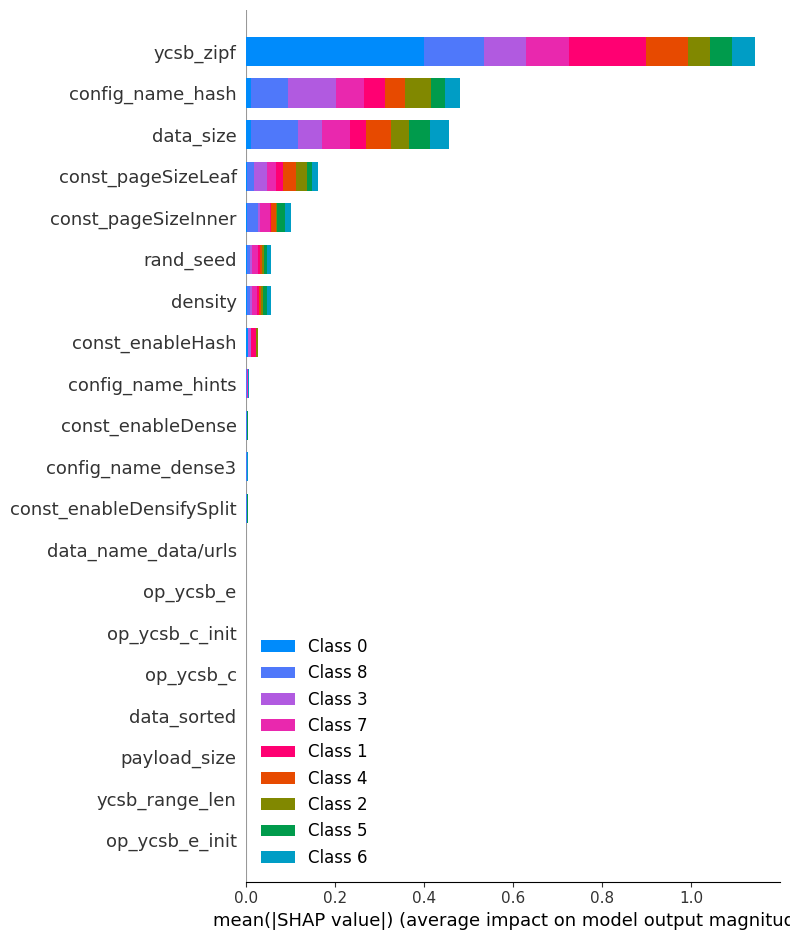

In [6]:
import shap
explainer = shap.Explainer(clf)

shap_values = explainer.shap_values(input_data)
shap.summary_plot(shap_values, input_data)